# YOLOv8 Model Comparison: Base vs Tank-Only vs Tank+COCO (Frozen Backbone)

This notebook compares three models:
1. **Base Model**: Original pretrained YOLOv8n on COCO (80 classes)
2. **Model 1 (Tank-Only)**: Trained only on Tank class
3. **Model 2 (Tank+COCO)**: Trained on Tank class with frozen COCO backbone

We will test all three models on:
- Tank images from test set
- Person images from the web (to verify COCO knowledge retention)

## 1. Setup and Imports

In [72]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import os
from pathlib import Path

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

## 2. Load All Three Models

In [73]:
# Model paths
# For Jupyter notebooks, use current working directory
import os
from pathlib import Path

# Get current directory and project root
CURRENT_DIR = Path(os.getcwd())
# If we're in tank.yolo8 folder, go up one level
if CURRENT_DIR.name == 'tank.yolo8':
    PROJECT_ROOT = CURRENT_DIR.parent
else:
    PROJECT_ROOT = CURRENT_DIR

# Model paths relative to project root  
TANK_ONLY_MODEL = CURRENT_DIR / "runs" / "detect" / "train_tank_only" / "weights" / "best.pt"
MERGED_MODEL = CURRENT_DIR / "runs" / "detect" / "train_with_coco" / "weights" / "best.pt"
BASE_MODEL = "yolov8n.pt"  # Will download if not exists

# Check if models exist
print("Checking models...")
print(f"Current directory: {CURRENT_DIR}")
print(f"Project root: {PROJECT_ROOT}")
print(f"✓ Base Model: {BASE_MODEL}")

if not TANK_ONLY_MODEL.exists():
    print(f"⚠️  Model 1 not found: {TANK_ONLY_MODEL}")
    print("Please train Model 1 first by running yolov8_train.py")
else:
    print(f"✓ Model 1 found: {TANK_ONLY_MODEL}")

if not MERGED_MODEL.exists():
    print(f"⚠️  Model 2 not found: {MERGED_MODEL}")
    print("Please train Model 2 first by running yolov8_train.py")
else:
    print(f"✓ Model 2 found: {MERGED_MODEL}")

# Load models
print("\nLoading models...")
base_model = YOLO(BASE_MODEL)  # Base pretrained model
model1 = YOLO(str(TANK_ONLY_MODEL)) if TANK_ONLY_MODEL.exists() else None  # Tank-only model
model2 = YOLO(str(MERGED_MODEL)) if MERGED_MODEL.exists() else None  # Tank+COCO model
print("✓ Models loaded successfully!")

if base_model:
    print(f"\nBase Model classes: {list(base_model.names.values())[:5]}... (total {len(base_model.names)} classes)")
if model1:
    print(f"Model 1 classes: {model1.names}")
if model2:
    print(f"Model 2 classes: {list(model2.names.values())[:5]}... (total {len(model2.names)} classes)")

Checking models...
Current directory: /home/jaehyun/yolo_train/tank.yolo8
Project root: /home/jaehyun/yolo_train
✓ Base Model: yolov8n.pt
✓ Model 1 found: /home/jaehyun/yolo_train/tank.yolo8/runs/detect/train_tank_only/weights/best.pt
✓ Model 2 found: /home/jaehyun/yolo_train/tank.yolo8/runs/detect/train_with_coco/weights/best.pt

Loading models...
✓ Models loaded successfully!

Base Model classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane']... (total 80 classes)
Model 1 classes: {0: 'Tank'}
Model 2 classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane']... (total 81 classes)


## 3. Helper Functions

In [74]:
def download_image_from_url(url):
    """
    Download an image from a URL.
    
    Args:
        url: Image URL
    
    Returns:
        PIL Image or None if failed
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None


def plot_comparison(img_path, results_base, results1, results2, title="Model Comparison"):
    """
    Plot side-by-side comparison of three model predictions.
    
    Args:
        img_path: Path to original image
        results_base: Results from base model
        results1: Results from model 1
        results2: Results from model 2
        title: Plot title
    """
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    
    # Load original image
    if isinstance(img_path, str):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = np.array(img_path)
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Base Model result
    img_base = results_base[0].plot()
    img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
    axes[1].imshow(img_base)
    axes[1].set_title(f"Base Model (COCO)\nDetections: {len(results_base[0].boxes)}", 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Model 1 result
    img1 = results1[0].plot()
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    axes[2].imshow(img1)
    axes[2].set_title(f"Model 1: Tank-Only\nDetections: {len(results1[0].boxes)}", 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    # Model 2 result
    img2 = results2[0].plot()
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    axes[3].imshow(img2)
    axes[3].set_title(f"Model 2: Tank+COCO (Frozen)\nDetections: {len(results2[0].boxes)}", 
                     fontsize=14, fontweight='bold')
    axes[3].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def print_detection_details(results, model_name):
    """
    Print detailed detection results.
    
    Args:
        results: YOLO results object
        model_name: Name of the model for display
    """
    print(f"\n{'='*60}")
    print(f"{model_name} - Detections")
    print(f"{'='*60}")
    
    if len(results[0].boxes) == 0:
        print("No objects detected")
    else:
        for i, box in enumerate(results[0].boxes):
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            cls_name = results[0].names[cls]
            coords = box.xyxy[0].tolist()
            print(f"  Detection {i+1}: {cls_name}")
            print(f"    Confidence: {conf:.2%}")
            print(f"    Bounding Box: [{coords[0]:.1f}, {coords[1]:.1f}, {coords[2]:.1f}, {coords[3]:.1f}]")
    print(f"{'='*60}")

## 4. Test on Tank Images (from test set)

Testing on: ../dataset_only_tank/test/images/tank_altay_l7_jpg.rf.820f183c57c418610dc88da35f763494.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 47.08%
    Bounding Box: [136.5, 262.5, 166.5, 296.2]
  Detection 2: truck
    Confidence: 30.67%
    Bounding Box: [91.7, 243.1, 265.7, 421.8]
  Detection 3: boat
    Confidence: 28.28%
    Bounding Box: [91.7, 199.3, 265.9, 421.8]
  Detection 4: boat
    Confidence: 25.32%
    Bounding Box: [91.1, 171.3, 265.7, 422.2]

Model 1 (Tank-Only) - Detections
No objects detected

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: Tank
    Confidence: 48.02%
    Bounding Box: [14.7, 238.7, 264.6, 421.2]


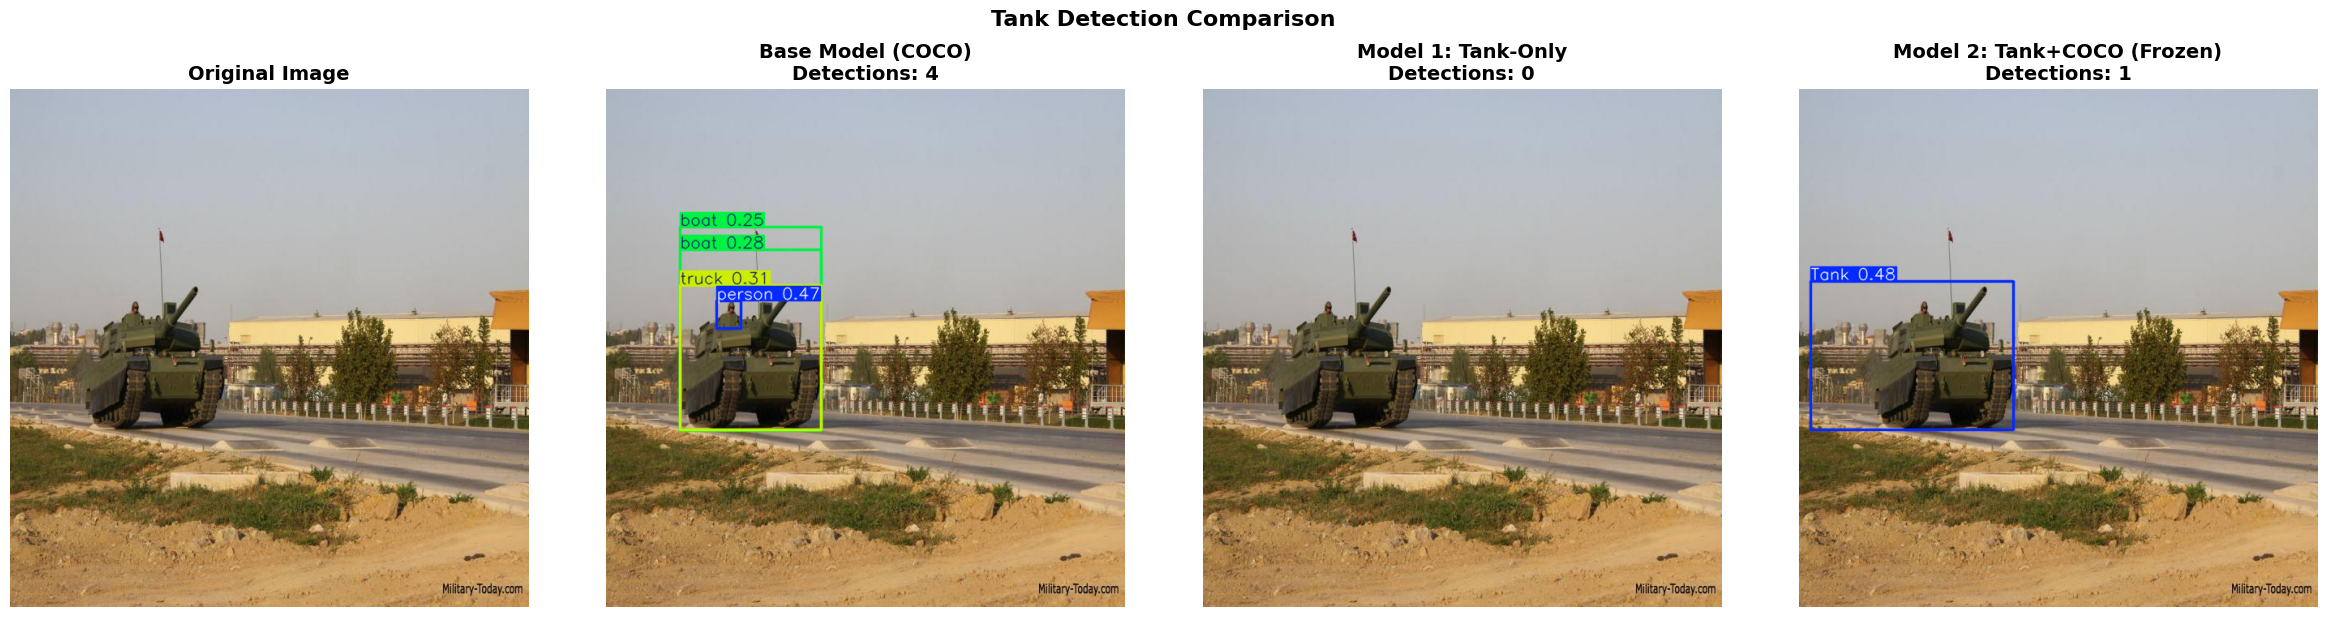

In [ ]:
# Get first tank image from test set
test_images = list(Path("../dataset_only_tank/valid/images").glob("*.jpg")) + list(Path("../dataset_only_tank/valid/images").glob("*.png"))

if len(test_images) > 0:
    test_img = str(test_images[0])
    print(f"Testing on: {test_img}")
    
    # Run inference with all three models
    results_base = base_model.predict(test_img, conf=0.25, verbose=False)
    results1 = model1.predict(test_img, conf=0.25, verbose=False)
    results2 = model2.predict(test_img, conf=0.25, verbose=False)
    
    # Print details
    print_detection_details(results_base, "Base Model (COCO)")
    print_detection_details(results1, "Model 1 (Tank-Only)")
    print_detection_details(results2, "Model 2 (Tank+COCO Frozen)")
    
    # Plot comparison
    plot_comparison(test_img, results_base, results1, results2, "Tank Detection Comparison")
else:
    print("⚠️  No test images found in ./test/images")

## 5. Test on Person Images (from web)

This test verifies if Model 2 and Base Model can detect persons, while Model 1 should not detect persons (no COCO knowledge).


Testing image 1/2...

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 90.47%
    Bounding Box: [0.0, 40.6, 640.0, 956.6]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 59.37%
    Bounding Box: [0.0, 16.6, 640.0, 956.5]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: person
    Confidence: 97.39%
    Bounding Box: [0.0, 40.1, 634.4, 960.0]


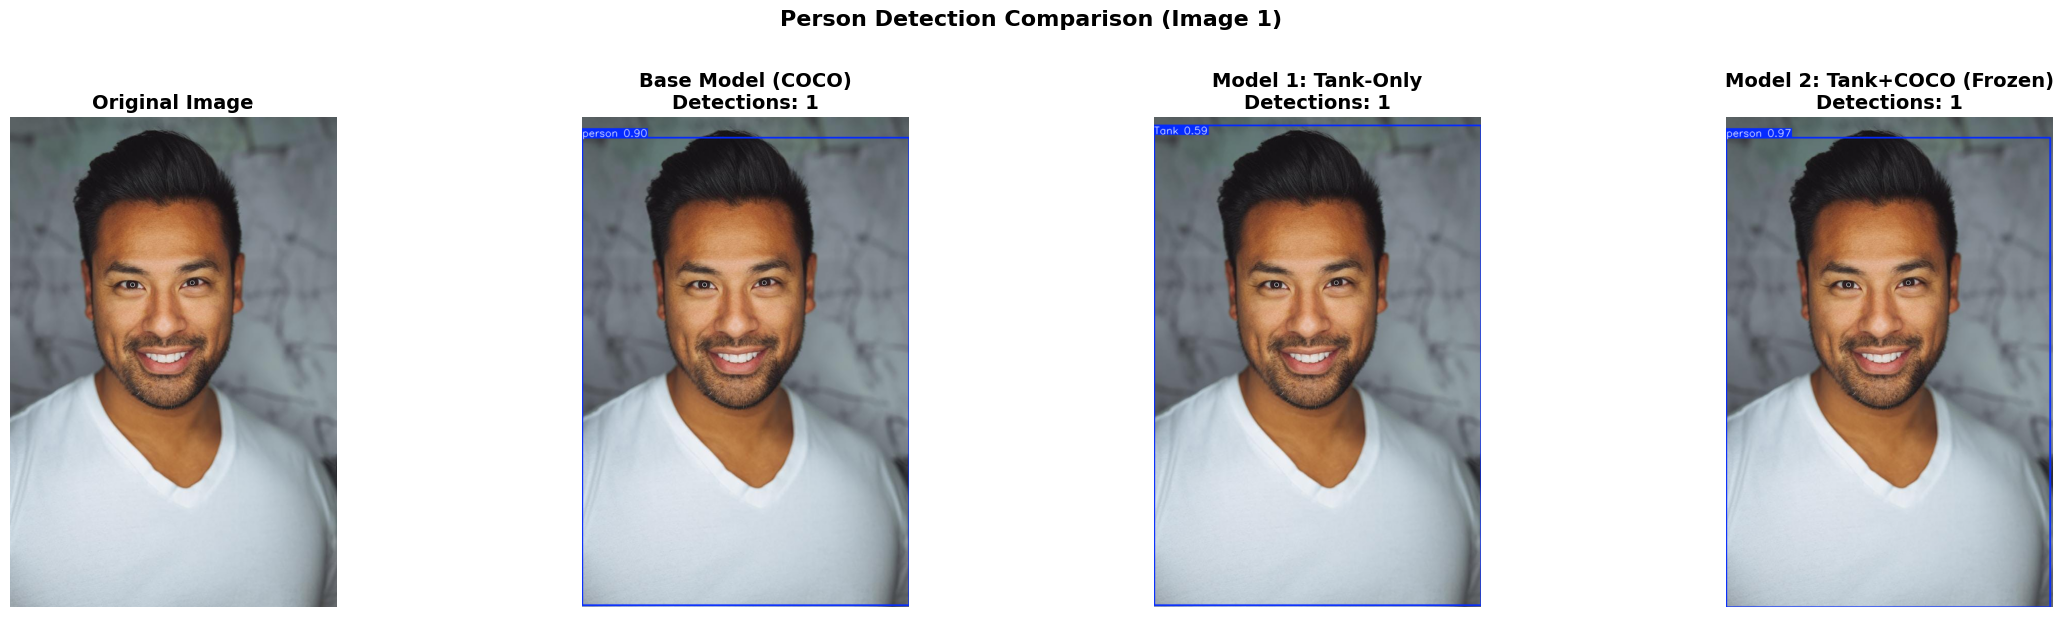


--------------------------------------------------------------------------------

Testing image 2/2...

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 90.20%
    Bounding Box: [0.0, 254.2, 639.0, 959.2]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 67.05%
    Bounding Box: [44.2, 32.8, 609.8, 875.2]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: person
    Confidence: 96.26%
    Bounding Box: [0.0, 252.5, 634.0, 959.3]


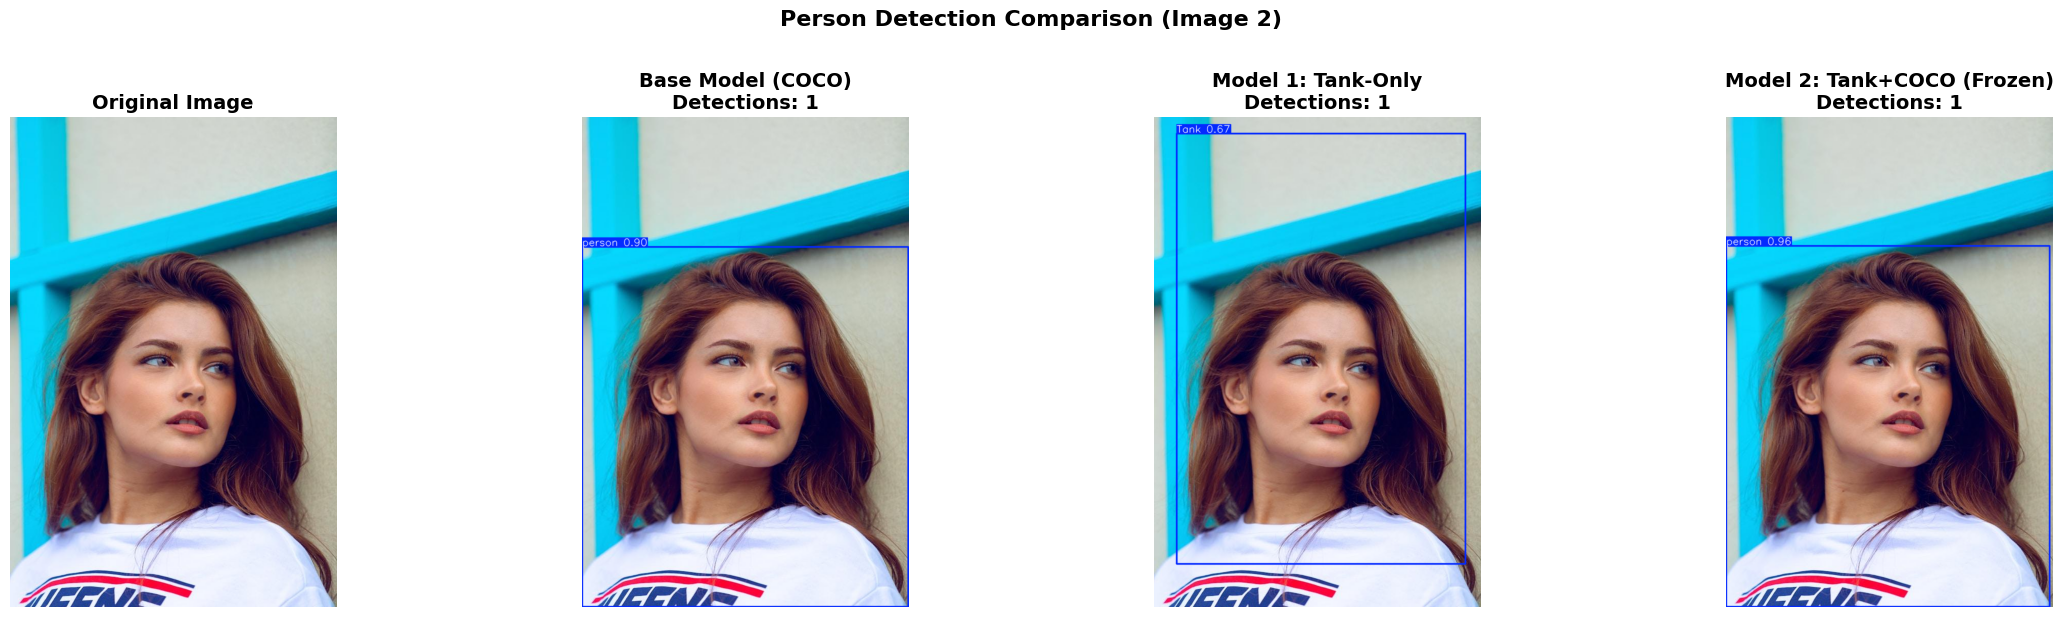


--------------------------------------------------------------------------------



In [76]:
# Download person images from web
person_image_urls = [
    "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=640", 
    "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e?w=640",  
]

print("Downloading person images from web...\n")

for i, url in enumerate(person_image_urls):
    print(f"Testing image {i+1}/{len(person_image_urls)}...")
    
    # Download image
    img = download_image_from_url(url)
    
    if img is None:
        print(f"  Failed to download image {i+1}")
        continue
    
    # Save temporarily
    temp_path = f"./temp_person_{i}.jpg"
    img.save(temp_path)
    
    # Run inference with all three models
    results_base = base_model.predict(temp_path, conf=0.25, verbose=False)
    results1 = model1.predict(temp_path, conf=0.25, verbose=False)
    results2 = model2.predict(temp_path, conf=0.25, verbose=False)
    
    # Print details
    print_detection_details(results_base, "Base Model (COCO)")
    print_detection_details(results1, "Model 1 (Tank-Only)")
    print_detection_details(results2, "Model 2 (Tank+COCO Frozen)")
    
    # Plot comparison
    plot_comparison(temp_path, results_base, results1, results2, f"Person Detection Comparison (Image {i+1})")
    
    # Clean up
    os.remove(temp_path)
    print("\n" + "-"*80 + "\n")

## 6. Custom Image URL Testing

Test with your own image URLs.

Testing custom image from: https://images.unsplash.com/photo-1506794778202-cad84cf45f1d?w=640


Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 93.82%
    Bounding Box: [1.6, 23.5, 636.4, 955.0]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 30.05%
    Bounding Box: [79.0, 0.0, 506.5, 643.9]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: person
    Confidence: 97.98%
    Bounding Box: [0.0, 17.8, 636.4, 955.1]


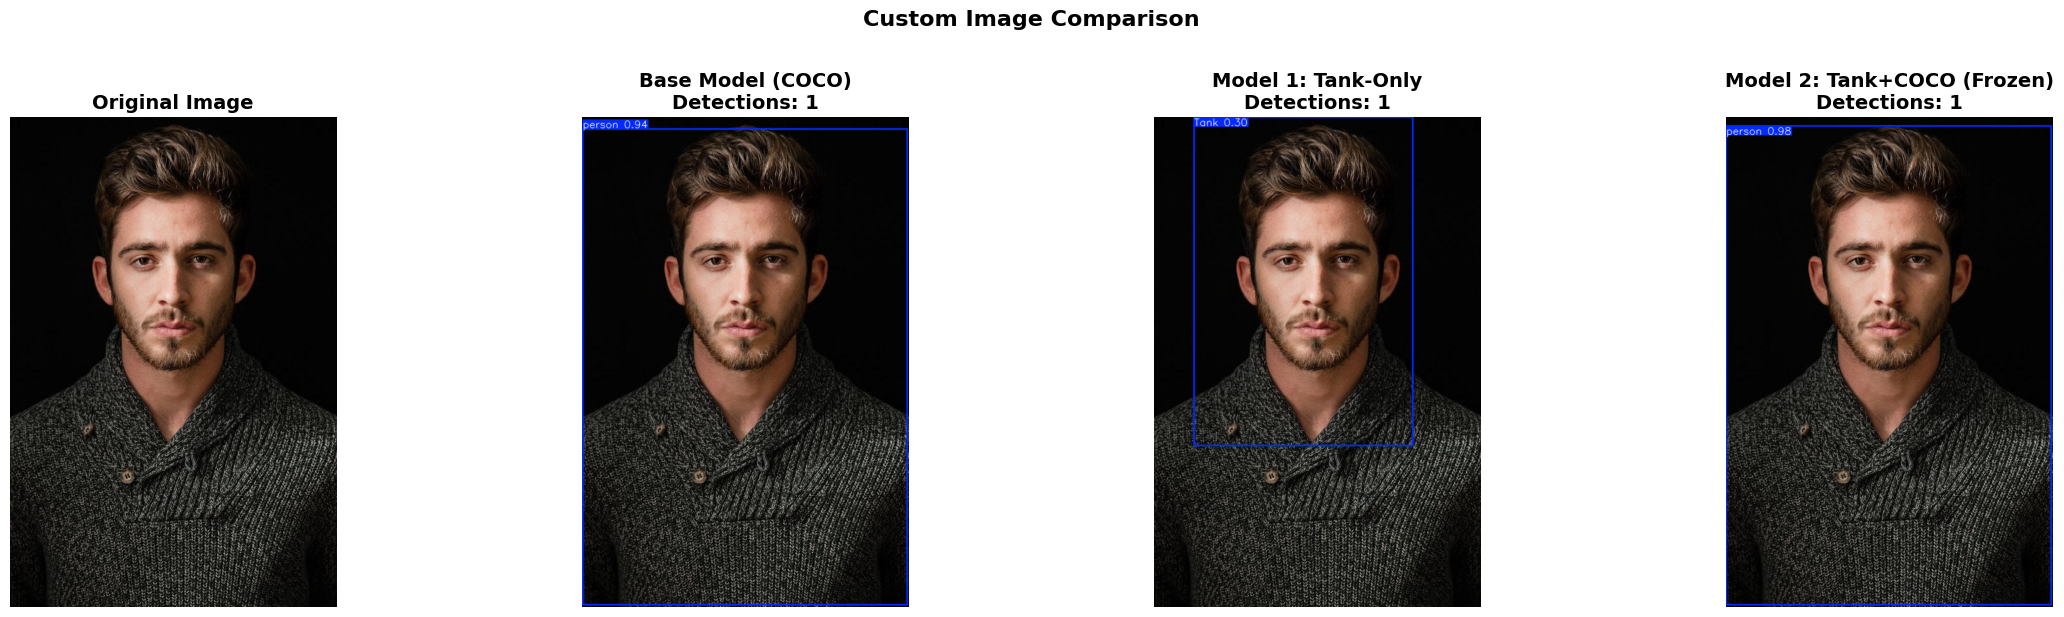

In [77]:
# Enter your custom image URL here
custom_url = "https://images.unsplash.com/photo-1506794778202-cad84cf45f1d?w=640"  # Change this URL

print(f"Testing custom image from: {custom_url}\n")

# Download image
img = download_image_from_url(custom_url)

if img is not None:
    # Save temporarily
    temp_path = "./temp_custom.jpg"
    img.save(temp_path)
    
    # Run inference with all three models
    results_base = base_model.predict(temp_path, conf=0.25, verbose=False)
    results1 = model1.predict(temp_path, conf=0.25, verbose=False)
    results2 = model2.predict(temp_path, conf=0.25, verbose=False)
    
    # Print details
    print_detection_details(results_base, "Base Model (COCO)")
    print_detection_details(results1, "Model 1 (Tank-Only)")
    print_detection_details(results2, "Model 2 (Tank+COCO Frozen)")
    
    # Plot comparison
    plot_comparison(temp_path, results_base, results1, results2, "Custom Image Comparison")
    
    # Clean up
    os.remove(temp_path)
else:
    print("Failed to download custom image")

## 7. Summary and Analysis

### Expected Results:

**Base Model (COCO)**:
- ❌ Should NOT detect tanks (not trained on Tank class)
- ✅ Should detect persons and other COCO objects
- Knows 80 COCO classes

**Model 1 (Tank-Only)**:
- ✅ Should detect tanks accurately
- ❌ Should NOT detect persons (not trained on COCO classes)
- Only knows class 0: Tank

**Model 2 (Tank+COCO Frozen Backbone)**:
- ✅ Should detect tanks accurately
- ✅ Should detect persons (COCO knowledge retained via frozen backbone)
- Knows 81 classes: 80 COCO classes + Tank (class 80)

### Key Insights:

1. **Catastrophic Forgetting Prevention**: Model 2 demonstrates that freezing the backbone preserves knowledge of COCO classes while learning new classes.

2. **Transfer Learning Benefit**: Model 2 leverages pre-trained COCO features, potentially achieving better generalization than Model 1.

3. **Base Model Limitation**: The base model cannot detect tanks because it was never trained on tank images.

4. **Use Cases**:
   - Use Base Model for general COCO object detection (no tanks)
   - Use Model 1 when you only need tank detection (lightweight, single class)
   - Use Model 2 when you need both tank detection AND COCO object detection (person, car, etc.)

### Comparison Table:

| Model | Tank Detection | Person Detection | Total Classes | Backbone Status |
|-------|---------------|------------------|---------------|-----------------|
| Base | ❌ | ✅ | 80 | Pretrained |
| Model 1 | ✅ | ❌ | 1 | Fine-tuned |
| Model 2 | ✅ | ✅ | 81 | Frozen (COCO preserved) |

## 8. Batch Testing on Multiple Images

Testing on 5 tank images...


Image 1/5: tank_altay_l7_jpg.rf.820f183c57c418610dc88da35f763494.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 47.08%
    Bounding Box: [136.5, 262.5, 166.5, 296.2]
  Detection 2: truck
    Confidence: 30.67%
    Bounding Box: [91.7, 243.1, 265.7, 421.8]
  Detection 3: boat
    Confidence: 28.28%
    Bounding Box: [91.7, 199.3, 265.9, 421.8]
  Detection 4: boat
    Confidence: 25.32%
    Bounding Box: [91.1, 171.3, 265.7, 422.2]

Model 1 (Tank-Only) - Detections
No objects detected

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: Tank
    Confidence: 48.02%
    Bounding Box: [14.7, 238.7, 264.6, 421.2]


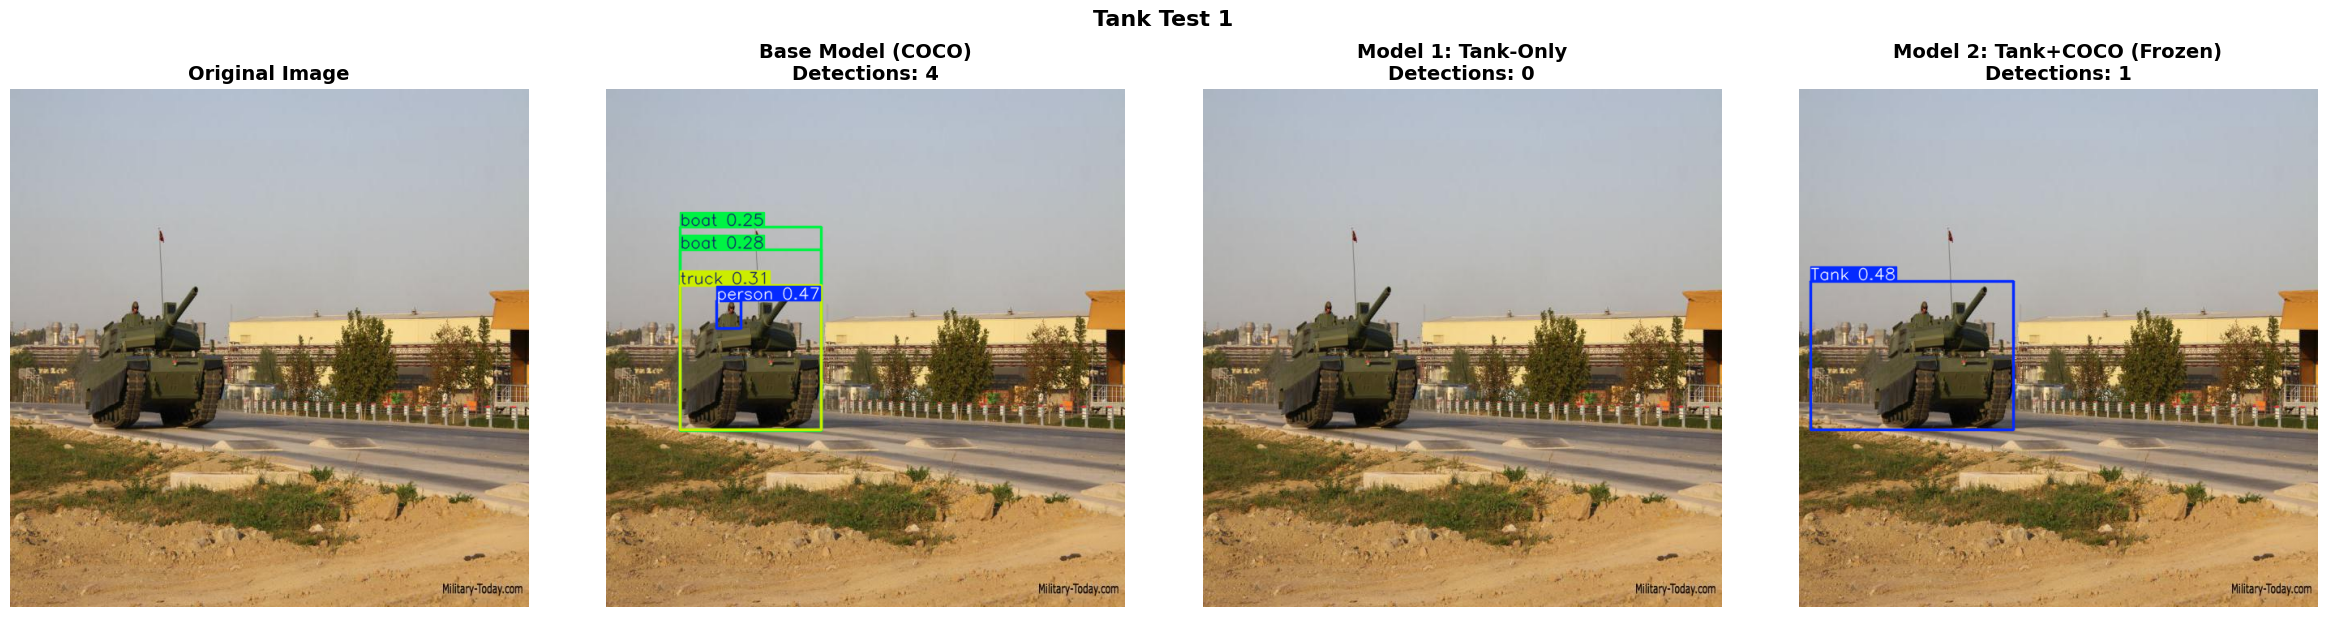


Image 2/5: tank_cv90105_l3_jpg.rf.6c07354202657f2810fc0689ec6d3c46.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 92.06%
    Bounding Box: [246.8, 306.0, 385.3, 639.8]
  Detection 2: person
    Confidence: 89.63%
    Bounding Box: [0.0, 338.2, 68.8, 640.0]
  Detection 3: person
    Confidence: 75.70%
    Bounding Box: [93.8, 362.1, 134.1, 524.0]
  Detection 4: tie
    Confidence: 35.13%
    Bounding Box: [13.4, 391.5, 26.5, 447.1]
  Detection 5: tie
    Confidence: 26.70%
    Bounding Box: [10.9, 390.5, 28.2, 473.7]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 91.01%
    Bounding Box: [0.0, 103.6, 630.7, 640.0]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: person
    Confidence: 93.34%
    Bounding Box: [247.3, 309.1, 385.5, 639.6]
  Detection 2: person
    Confidence: 88.53%
    Bounding Box: [0.0, 337.6, 67.9, 640.0]
  Detection 3: person
    Confidence: 87.44%
    Bounding Box: [93.5, 361.0, 133.2, 525.2]
  Detection 4: 

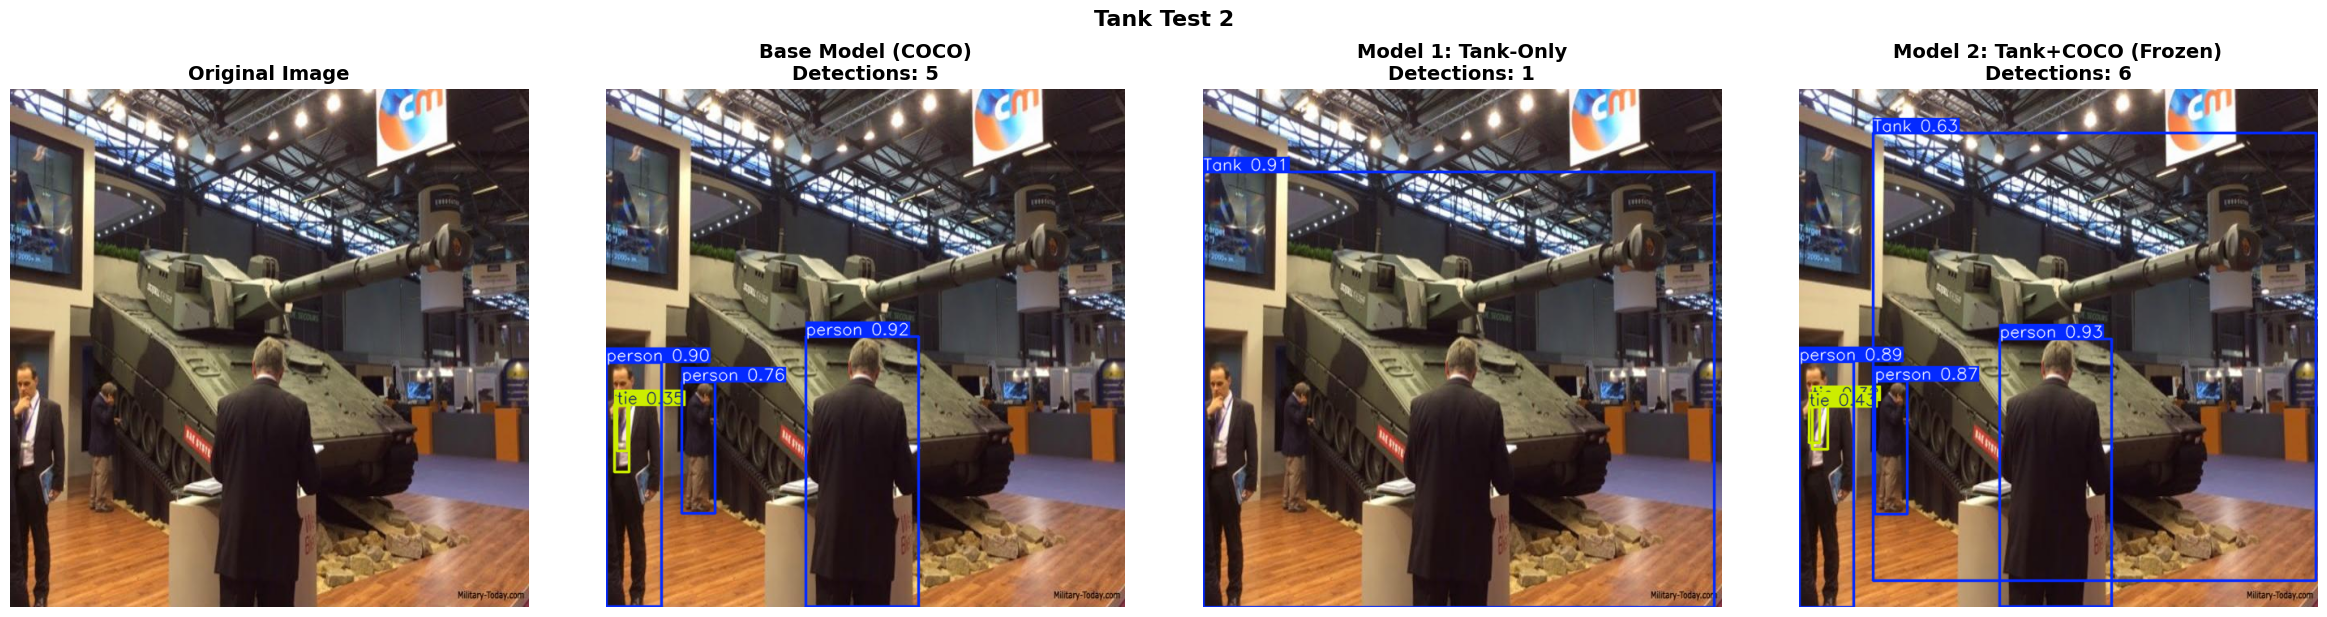


Image 3/5: tank_gl5_main_jpg.rf.e7ea30288dfb6b0da8627fdf3fb25fa7.jpg

Base Model (COCO) - Detections
  Detection 1: train
    Confidence: 48.58%
    Bounding Box: [1.2, 201.8, 579.1, 539.1]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 73.01%
    Bounding Box: [1.8, 191.7, 640.0, 518.7]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: Tank
    Confidence: 60.32%
    Bounding Box: [2.4, 165.5, 638.2, 539.3]


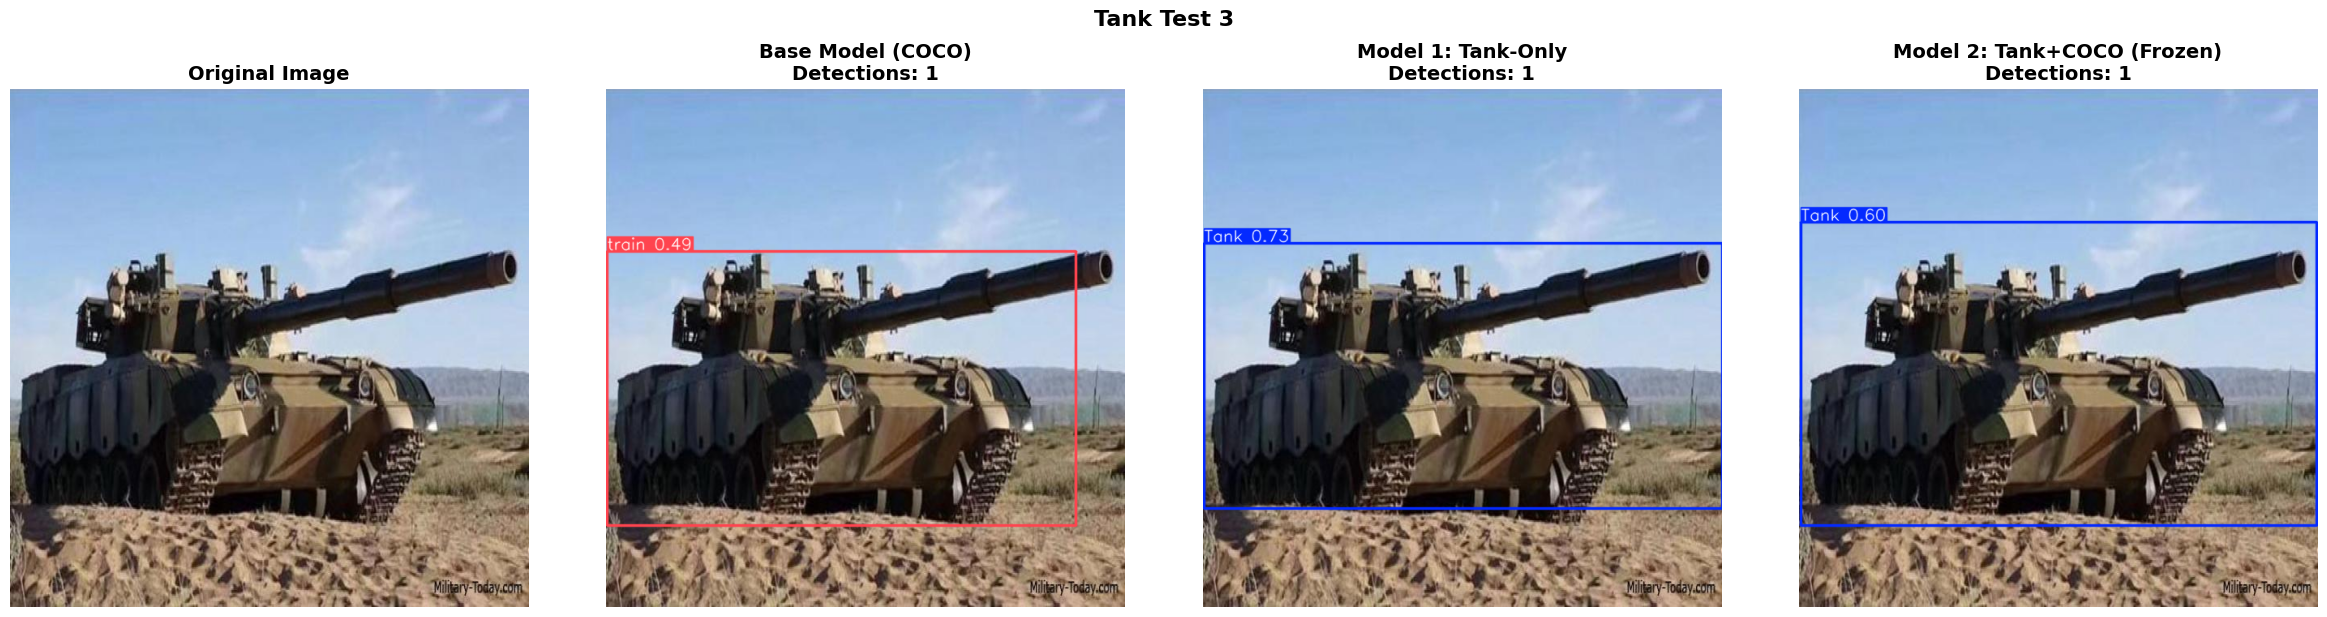


Image 4/5: tank_expeditionary_tank_l5_jpg.rf.283feb28dc52d2330dc7d554860b697b.jpg

Base Model (COCO) - Detections
  Detection 1: truck
    Confidence: 37.64%
    Bounding Box: [16.0, 341.8, 586.2, 584.9]
  Detection 2: truck
    Confidence: 25.84%
    Bounding Box: [13.5, 238.5, 593.6, 592.8]
  Detection 3: airplane
    Confidence: 25.23%
    Bounding Box: [13.8, 240.5, 589.1, 598.4]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 86.85%
    Bounding Box: [5.2, 120.0, 630.8, 571.2]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: airplane
    Confidence: 65.32%
    Bounding Box: [13.3, 165.8, 591.9, 588.1]


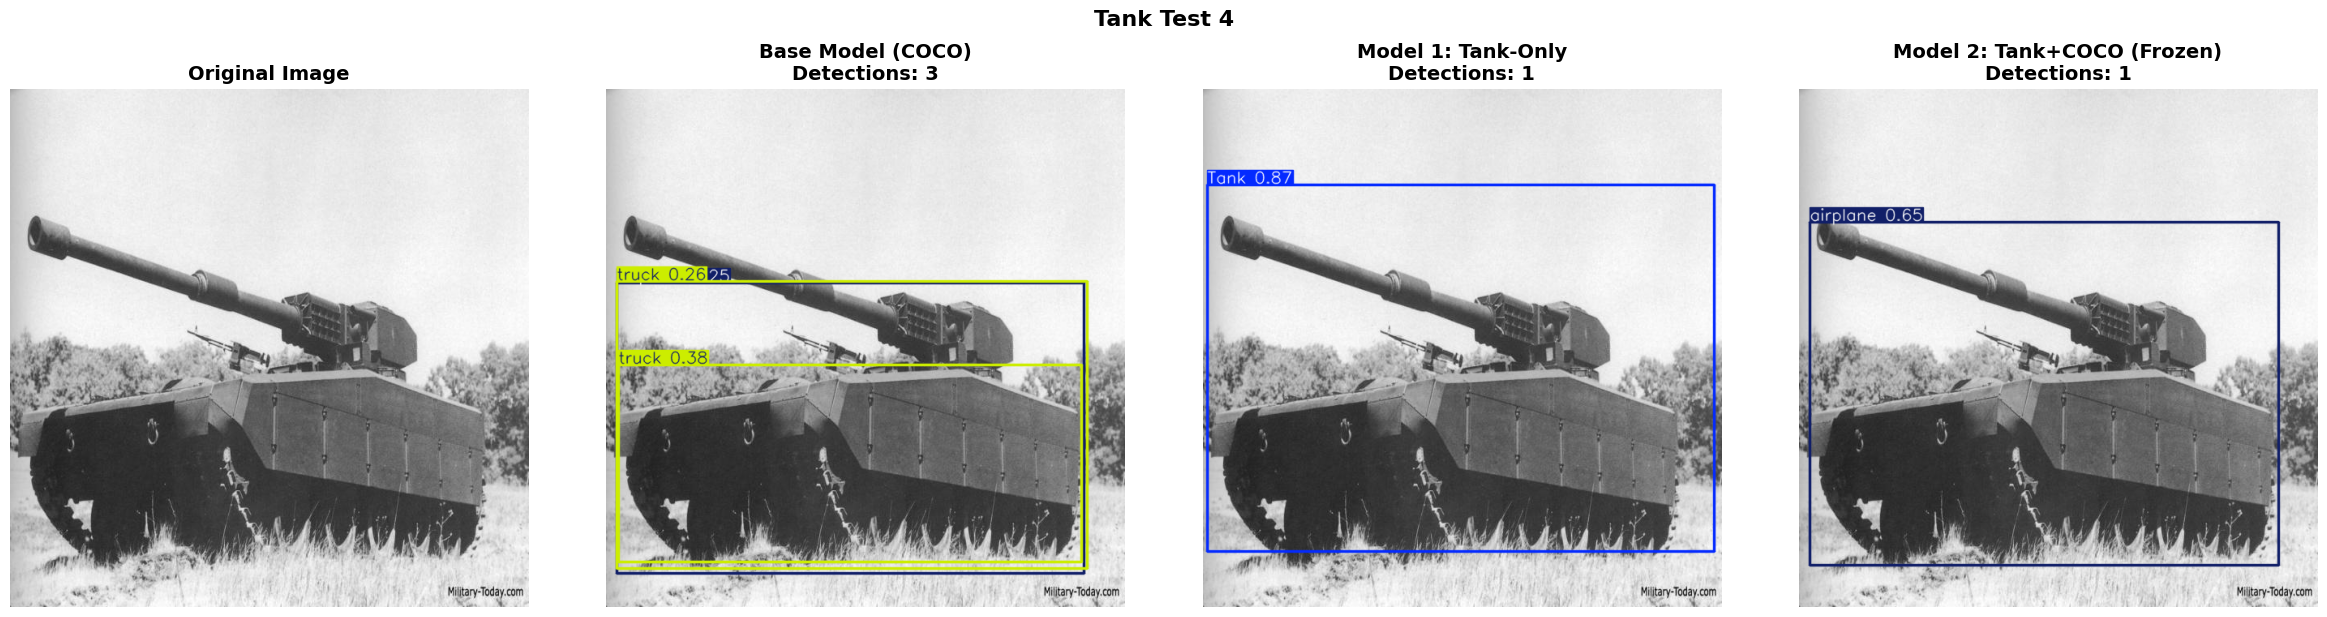


Image 5/5: tank_amx_13_main_jpg.rf.e48c07c9f1a7b5752d0e819cb6389731.jpg

Base Model (COCO) - Detections
  Detection 1: person
    Confidence: 80.61%
    Bounding Box: [394.8, 24.5, 483.5, 201.0]
  Detection 2: person
    Confidence: 68.59%
    Bounding Box: [285.7, 43.1, 381.4, 207.2]
  Detection 3: person
    Confidence: 31.46%
    Bounding Box: [118.8, 227.3, 206.2, 460.1]
  Detection 4: person
    Confidence: 27.10%
    Bounding Box: [120.3, 228.7, 204.6, 365.7]

Model 1 (Tank-Only) - Detections
  Detection 1: Tank
    Confidence: 80.67%
    Bounding Box: [0.0, 66.7, 635.0, 640.0]

Model 2 (Tank+COCO Frozen) - Detections
  Detection 1: person
    Confidence: 83.91%
    Bounding Box: [281.6, 45.7, 381.5, 205.2]
  Detection 2: person
    Confidence: 82.31%
    Bounding Box: [394.3, 25.1, 483.0, 199.0]
  Detection 3: Tank
    Confidence: 75.39%
    Bounding Box: [14.9, 38.9, 619.3, 585.9]
  Detection 4: person
    Confidence: 71.95%
    Bounding Box: [120.1, 227.5, 204.0, 453.5]
  Det

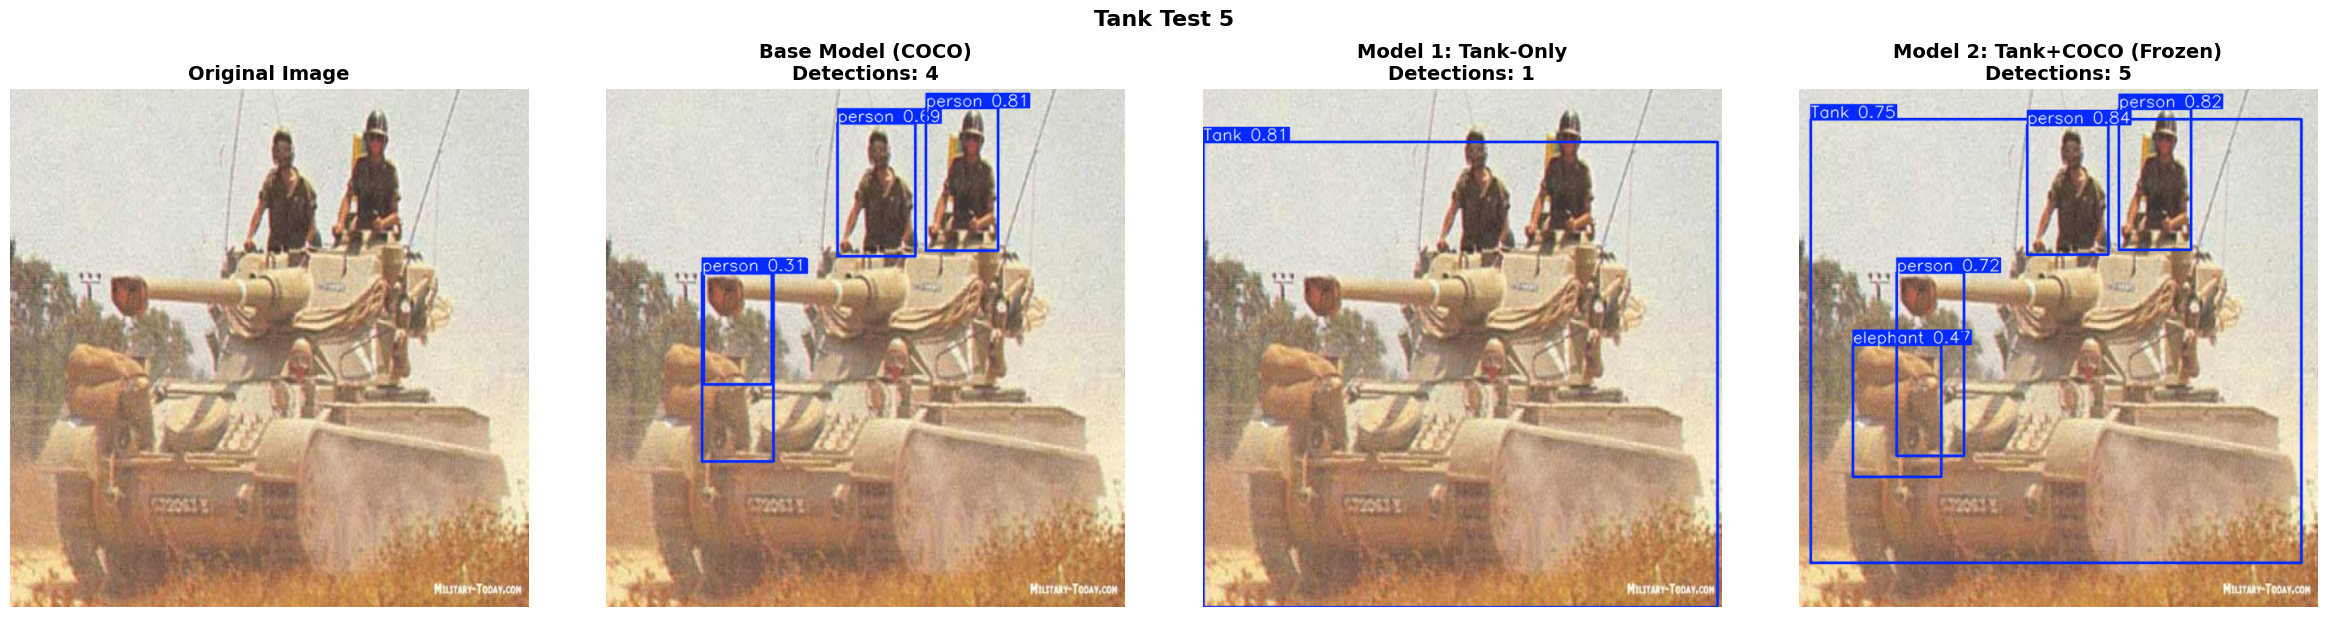

In [78]:
# Test on multiple tank images
test_images = list(Path("../dataset_only_tank/test/images").glob("*.jpg"))[:5]  # First 5 images

if len(test_images) > 0:
    print(f"Testing on {len(test_images)} tank images...\n")
    
    for i, img_path in enumerate(test_images):
        print(f"\n{'='*80}")
        print(f"Image {i+1}/{len(test_images)}: {img_path.name}")
        print(f"{'='*80}")
        
        # Run inference with all three models
        results_base = base_model.predict(str(img_path), conf=0.25, verbose=False)
        results1 = model1.predict(str(img_path), conf=0.25, verbose=False)
        results2 = model2.predict(str(img_path), conf=0.25, verbose=False)
        
        # Print details
        print_detection_details(results_base, "Base Model (COCO)")
        print_detection_details(results1, "Model 1 (Tank-Only)")
        print_detection_details(results2, "Model 2 (Tank+COCO Frozen)")
        
        # Plot comparison
        plot_comparison(str(img_path), results_base, results1, results2, f"Tank Test {i+1}")
else:
    print("⚠️  No test images found")